# 名義尺度の相関係数

**クラメールのV（Cramer's V）** あるいは **クラメールの連関係数（Cramer's coefficient of association）** と呼ばれる指標

$$
V=\sqrt{\frac{\chi^2}{n \times \min (r-1, c-1)}}
$$

はクロス集計表における行と列の関連性の強さ（独立性の弱さ）を示す指標。
$0 \leq V \leq 1$の値をとり、$1$に近いほど関連が強い。

In [1]:
import numpy as np
from scipy.stats import chi2_contingency

# クロス集計表（例：性別と購買の関係）
# 行：性別（男性, 女性）、列：購買した, 購買してない
data = np.array([
    [30, 10],  # 男性
    [20, 40]   # 女性
])

chi2, p, dof, expected = chi2_contingency(data)

print(f"""
カイ二乗統計量 (χ²): {chi2:.3f}
p-value: {p:.3f}
自由度: {dof}
期待度数:
{expected}
""")


カイ二乗統計量 (χ²): 15.042
p-value: 0.000
自由度: 1
期待度数:
[[20. 20.]
 [30. 30.]]



In [2]:
result = chi2_contingency(data)
chi2 = result.statistic

n = data.sum()
min_dim = min(data.shape) - 1  # k - 1
cramers_v = (chi2 / (n * min_dim)) ** 0.5

print(f"クラメールのV: {cramers_v:.3f}")


クラメールのV: 0.388


## 比較

連続変数を閾値で切って離散化したケース（Polychoric相関係数が想定するデータ生成過程）だとどうか。

データは標準正規分布から得られたとする

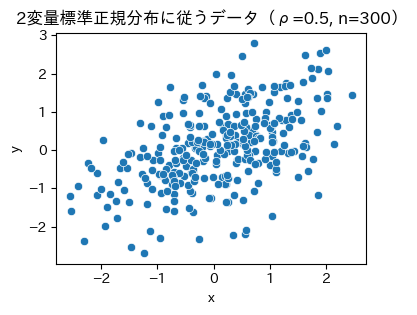

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

def gen_bivariate_normal(rho=0.5, size=1000):
    # 2変量標準正規分布によるデータ生成
    mean = [0, 0]
    std = [1, 1]
    cov = rho * std[0] * std[1]
    Cov = np.array([[std[0] ** 2, cov], [cov, std[1] ** 2]])
    X = multivariate_normal.rvs(mean=mean, cov=Cov, size=size, random_state=0)
    df = pd.DataFrame(X, columns=["x", "y"])
    return df


# データ生成
n = 300
rho = 0.5
continuous_data = gen_bivariate_normal(rho=rho, size=n)

# データをグラフにplot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_fontja

fig, ax = plt.subplots(figsize=[4, 3])

# 元データ
sns.scatterplot(data=continuous_data, x="x", y="y", ax=ax)
ax.set(title=f"2変量標準正規分布に従うデータ（ρ={rho}, n={n}）")
fig.show()

離散化してクロス表にするとこのような感じ。（y軸が散布図とは逆向きな点に注意）

In [4]:
# 離散化のイメージ
k = 5
x, _ = pd.cut(continuous_data["x"], bins=k).factorize(sort=True)
y, _ = pd.cut(continuous_data["y"], bins=k).factorize(sort=True)

table = pd.crosstab(index=y, columns=x, rownames=["y"], colnames=["x"])

# NOTE: クロス表の縦軸は下にいくほど値が大きく、散布図とは逆転している
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
table.style.background_gradient(cmap=cm)

x,0,1,2,3,4
y,,,,,
0,3,4,3,3,0
1,11,29,26,6,3
2,5,22,47,41,7
3,0,9,23,34,9
4,0,0,3,4,8


上の例だとこのような結果になる

In [5]:
def cramerv(x, y):
    table = pd.crosstab(index=y, columns=x, rownames=["y"], colnames=["x"])
    result = chi2_contingency(table)
    chi2 = result.statistic
    n = data.sum()
    min_dim = min(data.shape) - 1  # k - 1
    cramers_v = (chi2 / (n * min_dim)) ** 0.5
    return cramers_v



from ordinalcorr import polychoric
from scipy.stats import pearsonr, spearmanr, kendalltau
 
print(f"""
Polychoric: {polychoric(x, y):.3f}
Cramer's V: {cramerv(x, y):.3f}

Pearson: {pearsonr(x, y).statistic:.3f}
Spearman: {spearmanr(x, y).statistic:.3f}
Kendall: {kendalltau(x, y).statistic:.3f}
""")


Polychoric: 0.506
Cramer's V: 0.991

Pearson: 0.460
Spearman: 0.455
Kendall: 0.394



いろいろなカテゴリ数で比較

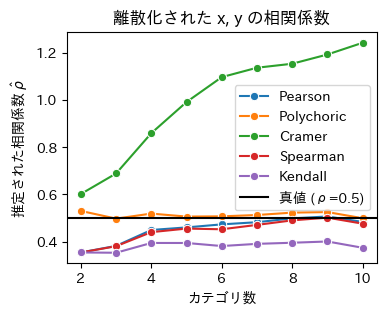

In [6]:
from ordinalcorr import polychoric
from scipy.stats import pearsonr, spearmanr, kendalltau

# 離散化のカテゴリ数を変えつつ相関係数を算出
results = []
for k in range(2, 11):
    x, _ = pd.cut(continuous_data["x"], bins=k).factorize(sort=True)
    y, _ = pd.cut(continuous_data["y"], bins=k).factorize(sort=True)
    results += [
        dict(method="Pearson", value=pearsonr(x, y).statistic, k=k),
        dict(method="Polychoric", value=polychoric(x, y), k=k),
        dict(method="Cramer", value=cramerv(x, y), k=k),
        dict(method="Spearman", value=spearmanr(x, y).statistic, k=k),
        dict(method="Kendall", value=kendalltau(x, y).statistic, k=k),
    ]
results = pd.DataFrame(results)

# データをグラフにplot
fig, ax = plt.subplots(figsize=[4, 3])
sns.lineplot(x="k", y="value", data=results, hue="method", marker="o", ax=ax)
ax.axhline(rho, label=f"真値 (ρ={rho})", color="black")
ax.set(
    xlabel="カテゴリ数",
    ylabel=r"推定された相関係数 $\hat{\rho}$",
    title="離散化された x, y の相関係数"
)
ax.legend()
fig.show()

Cramer's Vはこういった状況だとカテゴリ数に依存してバイアスが入る様子